In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [15]:
os.listdir('data/training/training')

['n6', 'n5', 'n0', 'n7', 'n8', 'n9', 'n1', 'n3', 'n4', 'n2']

In [27]:
train_data_set_path = 'data/training/training'
test_data_set_path =  'data/validation/validation'

In [28]:
training_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [29]:
training_dataset = torchvision.datasets.ImageFolder(root = train_data_set_path, transform = training_transform)

In [34]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 32, shuffle = False)

In [ ]:
next(iter(train_loader))

In [57]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    Total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        Total_images_count += image_count_in_a_batch
    mean /= Total_images_count
    std  /= Total_images_count

    return mean,std

In [58]:
get_mean_and_std(train_loader)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2129, 0.2075, 0.2038]))

In [62]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]
train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [64]:
train_dataset = torchvision.datasets.ImageFolder(root = train_data_set_path, transform =train_transforms )
test_dataset = torchvision.datasets.ImageFolder(root = test_data_set_path, transform = test_transforms)

In [72]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6,shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labes:',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labes: tensor([9, 8, 5, 3, 1, 3])


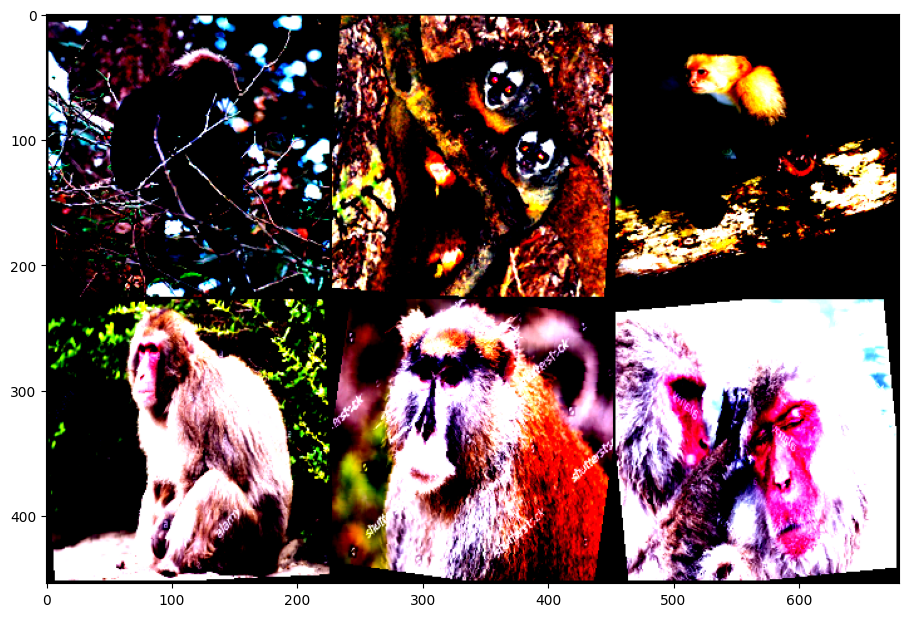

In [73]:
show_transformed_images(train_dataset)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batchsize = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batchsize = 32, shuffle = False)

In [75]:
def set_device():
    if torch.cuda.is_available():
        print('cuda gpu is available')
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)     

In [76]:
set_device()

cuda gpu is available


device(type='cuda', index=0)

In [ ]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, epoch):

In [ ]:
def evaluate_model_on_test_dataset(model, test_loader):

In [77]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained = False)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters, lr=0.01, momentum=0.9, weight_decay=0.003)